In [1]:
#Hello this the test file
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Rescaling,InputLayer, regularization
from keras.layers import Conv2D, MaxPool2D, Input
import matplotlib.pylab as plt
from tensorflow.python.client import device_lib
from keras.callbacks import CSVLogger
from keras.utils import plot_model
from keras.regularizers import l2 # ridge regression
from keras.regularizers import l1 # lasso regression

from keras.optimizers import Adam, SGD, RMSprop, Adamax
from keras import mixed_precision
import pandas as pd
import numpy as np
import os
import sys

file_dir = os.path.realpath(os.path.dirname('__file__'))

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print(device_lib.list_local_devices())

#GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)



Num GPUs Available:  1


In [3]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

def convert_sample(sample):
    #alternativ use
    #image, label = sample['image'], sample['label']
    image = sample['image']
    label = sample['label']
    image = tf.image.convert_image_dtype(image, tf.float16)
    label =tf.one_hot(label, 2, dtype=tf.bfloat16)
    return image, label


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [4]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:60%]','test[:10%]','validation[:10%]'],
                        data_dir = file_dir,
                        download=False,
                        shuffle_files=True)

In [5]:
tf.keras.backend.clear_session()
train_ds = ds1.map(convert_sample).batch(128)
test_ds = ds2.map(convert_sample).batch(128)
val_ds = ds3.map(convert_sample).batch(128)

In [6]:
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights = 'imagenet',
    input_shape = (96,96,3)
)

In [7]:
base_model.trainable = True
# for layer in base_model.layers[-3:]:
#   layer.trainable = True


In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal',input_shape=(96,96,3))
])

In [9]:
tf.keras.backend.clear_session()

In [10]:
#Name transfer_model_ResNet50



transfer_model_ResNet50 = tf.keras.models.Sequential ([
    data_augmentation,
    base_model,
    Flatten(),
    Dense(128,activation = 'relu'),
    Dense(2,activation='softmax')
])

transfer_model_ResNet50.compile(loss='categorical_crossentropy',
                          optimizer =Adam(learning_rate=0.001),
                          metrics=['accuracy'])

transfer_model_ResNet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 25,947,394
Trainable params: 25,894,274
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
tf.keras.backend.clear_session()

history_transfer_model =transfer_model_ResNet50.fit(train_ds,epochs = 30,validation_data=val_ds)

#Create a dataframe with the results
df_transfer_model = pd.DataFrame()

tf.keras.models.save_model(transfer_model_ResNet50, file_dir + r'\transfer_model_ResNet50', 
    save_format= 'tf', include_optimizer=True)

#Save the history of the model
df_transfer_model['transfer_ResNet50_acc'] = history_transfer_model.history['accuracy']
df_transfer_model['transfer_ResNet50_val_acc'] = history_transfer_model.history['val_accuracy']
df_transfer_model['transfer_ResNet50_loss'] = history_transfer_model.history['loss']
df_transfer_model['transfer_ResNet50_val_loss'] = history_transfer_model.history['val_loss']

df_transfer_model.to_csv(file_dir + r'\transfer_model_ResNet50.csv')

del transfer_model_ResNet50, history_transfer_model

Epoch 1/30


C:\Users\mikae\AppData\Local\Temp\ipykernel_18268\2077863972.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_transfer_model =transfer_model_ResNet50.fit_generator(train_ds,epochs = 30,validation_data=val_ds)


410/410 [==============================] - 97s 209ms/step - loss: 0.3674 - accuracy: 0.8822 - val_loss: 11.8771 - val_accuracy: 0.5069
Epoch 2/30
410/410 [==============================] - 84s 206ms/step - loss: 0.1957 - accuracy: 0.9274 - val_loss: 4.1191 - val_accuracy: 0.5630
Epoch 3/30
410/410 [==============================] - 85s 206ms/step - loss: 0.1534 - accuracy: 0.9436 - val_loss: 0.8778 - val_accuracy: 0.7864
Epoch 4/30
410/410 [==============================] - 84s 206ms/step - loss: 0.1560 - accuracy: 0.9435 - val_loss: 0.4291 - val_accuracy: 0.8709
Epoch 5/30
410/410 [==============================] - 85s 207ms/step - loss: 0.1190 - accuracy: 0.9567 - val_loss: 0.9344 - val_accuracy: 0.8105
Epoch 6/30
410/410 [==============================] - 85s 206ms/step - loss: 0.1158 - accuracy: 0.9586 - val_loss: 0.6723 - val_accuracy: 0.7910
Epoch 7/30
410/410 [==============================] - 86s 209ms/step - loss: 0.1593 - accuracy: 0.9425 - val_loss: 1.2601 - val_accuracy: 0.

INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\transfer_model_ResNet50\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\transfer_model_ResNet50\assets


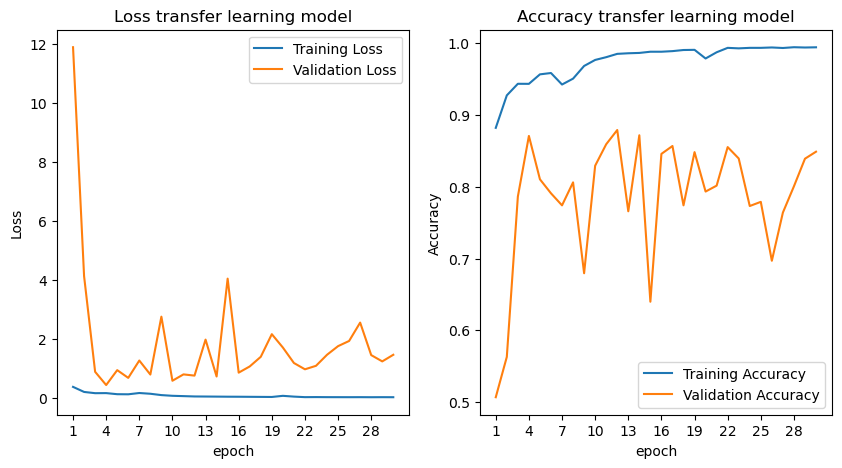

In [6]:
#load cvs file
df_transfer_model = pd.read_csv(file_dir + r'\transfer_model_ResNet50.csv')


#Plot figure transfer model

df_transfer_model.index = df_transfer_model.index + 1 

plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.plot(df_transfer_model['transfer_ResNet50_acc'], label='Training Accuracy')
plt.plot(df_transfer_model['transfer_ResNet50_val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(1, 30, 3))
plt.title('Accuracy transfer learning model')

plt.subplot(1,2,1)
plt.plot(df_transfer_model['transfer_ResNet50_loss'], label='Training Loss')
plt.plot(df_transfer_model['transfer_ResNet50_val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Loss transfer learning model')
plt.xlabel('epoch')
plt.xticks(np.arange(1, 30, 3))
plt.show()

In [12]:
#Load transfer model and evaluate
transfer_model_ResNet50 = tf.keras.models.load_model(file_dir + r'\transfer_model_ResNet50')
print(f'Transfer model test accuracy:  {round(transfer_model_ResNet50.evaluate(test_ds)[1]*100, 2)}% ')
print(f'Transfer model val accuracy:  {round(transfer_model_ResNet50.evaluate(val_ds)[1]*100, 2)}%')



13/13 [==============================] - 6s 96ms/step - loss: 1.6854 - accuracy: 0.8081
Transfer model test accuracy:  80.8% 
13/13 [==============================] - 1s 82ms/step - loss: 1.4547 - accuracy: 0.8489
Transfer model val accuracy:  84.8947%


In [11]:
#Further training of the transfer model with the same data
tf.keras.backend.clear_session()
transfer_model_ResNet50 = tf.keras.models.load_model(file_dir + r'\transfer_model_ResNet50')
history_transfer_model =transfer_model_ResNet50.fit(train_ds,epochs = 70,validation_data=val_ds)

tf.keras.models.save_model(transfer_model_ResNet50, file_dir + r'\transfer_model_ResNet50',
    save_format= 'tf', include_optimizer=True)

#Save the history of the model
df_transfer_model_further_training = pd.DataFrame()
df_transfer_model_further_training['transfer_ResNet50_acc'] = history_transfer_model.history['accuracy']
df_transfer_model_further_training['transfer_ResNet50_val_acc'] = history_transfer_model.history['val_accuracy']
df_transfer_model_further_training['transfer_ResNet50_loss'] = history_transfer_model.history['loss']
df_transfer_model_further_training['transfer_ResNet50_val_loss'] = history_transfer_model.history['val_loss']

df_transfer_model_further_training.to_csv(file_dir + r'\transfer_model_ResNet50_further_training.csv')

Epoch 1/70
410/410 [==============================] - 101s 214ms/step - loss: 0.1741 - accuracy: 0.9382 - val_loss: 0.2609 - val_accuracy: 0.9008
Epoch 2/70
410/410 [==============================] - 86s 209ms/step - loss: 0.0896 - accuracy: 0.9669 - val_loss: 0.3877 - val_accuracy: 0.8770
Epoch 3/70
410/410 [==============================] - 86s 211ms/step - loss: 0.0553 - accuracy: 0.9800 - val_loss: 0.7008 - val_accuracy: 0.8569
Epoch 4/70
410/410 [==============================] - 87s 211ms/step - loss: 0.0426 - accuracy: 0.9842 - val_loss: 1.0545 - val_accuracy: 0.8087
Epoch 5/70
410/410 [==============================] - 85s 208ms/step - loss: 0.0331 - accuracy: 0.9885 - val_loss: 0.6570 - val_accuracy: 0.8731
Epoch 6/70
410/410 [==============================] - 84s 206ms/step - loss: 0.0312 - accuracy: 0.9887 - val_loss: 1.1183 - val_accuracy: 0.8404
Epoch 7/70
410/410 [==============================] - 84s 206ms/step - loss: 0.0240 - accuracy: 0.9917 - val_loss: 0.9216 - val_a

INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\transfer_model_ResNet50\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\transfer_model_ResNet50\assets


In [13]:


print(f'Transfer model test accuracy:  {round(transfer_model_ResNet50.evaluate(test_ds)[1]*100, 2)}% ')
print(f'Transfer model val accuracy:  {round(transfer_model_ResNet50.evaluate(val_ds)[1]*100, 2)}%')

26/26 [==============================] - 2s 47ms/step - loss: 1.9641 - accuracy: 0.8016
Transfer model test accuracy:  80.16% 
26/26 [==============================] - 1s 46ms/step - loss: 1.1814 - accuracy: 0.8477
Transfer model val accuracy:  84.77%


In [6]:
tf.keras.backend.clear_session()
transfer_model_ResNet50 = tf.keras.models.load_model(file_dir + r'\transfer_model_ResNet50')
history_transfer_model =transfer_model_ResNet50.fit(train_ds,epochs = 20,validation_data=val_ds)

tf.keras.models.save_model(transfer_model_ResNet50, file_dir + r'\transfer_model_ResNet50_data_60',
    save_format= 'tf', include_optimizer=True)

Epoch 1/20
1229/1229 [==============================] - 275s 213ms/step - loss: 0.0963 - accuracy: 0.9701 - val_loss: 1.2265 - val_accuracy: 0.7305
Epoch 2/20
1229/1229 [==============================] - 261s 212ms/step - loss: 0.0832 - accuracy: 0.9783 - val_loss: 0.5453 - val_accuracy: 0.8303
Epoch 3/20
1229/1229 [==============================] - 257s 209ms/step - loss: 0.0436 - accuracy: 0.9906 - val_loss: 0.8836 - val_accuracy: 0.8123
Epoch 4/20
1229/1229 [==============================] - 257s 209ms/step - loss: 0.0353 - accuracy: 0.9873 - val_loss: nan - val_accuracy: 0.8544
Epoch 5/20
1229/1229 [==============================] - 257s 209ms/step - loss: 0.0220 - accuracy: 0.9923 - val_loss: nan - val_accuracy: 0.8084
Epoch 6/20
1229/1229 [==============================] - 257s 209ms/step - loss: 0.0345 - accuracy: 0.9954 - val_loss: nan - val_accuracy: 0.8230
Epoch 7/20
1229/1229 [==============================] - 258s 210ms/step - loss: 0.0351 - accuracy: 0.9952 - val_loss: nan

INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\transfer_model_ResNet50_data_60\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\transfer_model_ResNet50_data_60\assets


In [7]:
print(f'Transfer model test accuracy:  {round(transfer_model_ResNet50.evaluate(test_ds)[1]*100, 2)}% ')
print(f'Transfer model val accuracy:  {round(transfer_model_ResNet50.evaluate(val_ds)[1]*100, 2)}%')

26/26 [==============================] - 2s 46ms/step - loss: 1.2622 - accuracy: 0.8212
Transfer model test accuracy:  82.12% 
26/26 [==============================] - 1s 45ms/step - loss: 1.0317 - accuracy: 0.8740
Transfer model val accuracy:  87.4%
